In [1]:
# Single cell: Feature engineering + robust model tuning + stacking + save
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pickle, warnings, importlib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
# --------- Helper: compute RSI ----------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=period).mean()
    loss = -delta.clip(upper=0).rolling(window=period).mean()
    rs = gain / (loss.replace(0, 1e-8))
    return 100 - (100 / (1 + rs))

In [3]:
# --------- Load data (adjust filename if needed) ----------
df = pd.read_csv('Tesla.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [5]:
# drop unused column if present
if 'Adj_Close' in df.columns:
    df = df.drop(['Adj_Close'], axis=1)

In [6]:
# --------- Feature engineering (rich technical features) ----------
df['return_1'] = df['Close'].pct_change(1)
df['return_3'] = df['Close'].pct_change(3)
df['return_7'] = df['Close'].pct_change(7)

# moving averages
df['sma_5'] = df['Close'].rolling(5).mean()
df['sma_10'] = df['Close'].rolling(10).mean()
df['sma_20'] = df['Close'].rolling(20).mean()

# exponential moving averages
df['ema_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['ema_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# volatility
df['vol_5'] = df['Close'].rolling(5).std()
df['vol_10'] = df['Close'].rolling(10).std()

# momentum / price diff
df['mom_3'] = df['Close'] - df['Close'].shift(3)
df['mom_7'] = df['Close'] - df['Close'].shift(7)

# volume features
df['vol_change'] = df['Volume'].pct_change()
df['vol_ratio_5'] = df['Volume'] / (df['Volume'].rolling(5).mean().replace(0, np.nan))

# RSI
df['rsi_14'] = compute_rsi(df['Close'], 14)

# date features
df['month'] = df['Date'].dt.month
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_quarter_end'] = (df['month'] % 3 == 0).astype(int)

# lag features for price & volume
for lag in [1,2,3,5]:
    df[f'close_lag_{lag}'] = df['Close'].shift(lag)
    df[f'vol_lag_{lag}'] = df['Volume'].shift(lag)

# target: direction next day (1 if next close > today close)
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# drop rows with NaNs created by indicators
df = df.dropna().reset_index(drop=True)


In [7]:
# ---------- Select features ----------
feature_cols = [
    'Open','High','Low','Close','Volume',
    'return_1','return_3','return_7',
    'sma_5','sma_10','sma_20','ema_10','ema_20',
    'vol_5','vol_10','mom_3','mom_7',
    'vol_change','vol_ratio_5','rsi_14',
    'month','dayofweek','is_quarter_end',
    'close_lag_1','close_lag_2','close_lag_3','close_lag_5',
    'vol_lag_1','vol_lag_2','vol_lag_3','vol_lag_5'
]

X = df[feature_cols].copy()
y = df['target'].copy()

In [8]:
# If classes extremely imbalanced, user can adjust thresholds or use resampling - we keep full data for now.
print("Dataset shape:", X.shape, "Positives:", y.sum(), "Negatives:", (y==0).sum())

Dataset shape: (1673, 31) Positives: 858 Negatives: 815


In [9]:
# --------- Train/validation split - preserve time order ----------
train_size = 0.8
split_index = int(len(X) * train_size)
X_train, X_valid = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_valid = y.iloc[:split_index], y.iloc[split_index:]

In [10]:
# --------- Scaling ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


In [11]:
# --------- Models and param grids (with fallbacks if libs missing) ----------
models_to_try = {}
param_grids = {}

In [13]:
# RandomForest (always available)
models_to_try['rf'] = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grids['rf'] = {
    'n_estimators': [200, 400],
    'max_depth': [4, 6, 8],
    'class_weight': [None, 'balanced']
}

# XGBoost (if installed)
try:
    import xgboost
    models_to_try['xgb'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
    param_grids['xgb'] = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
except Exception as e:
    print("xgboost not available:", e)

# LightGBM (optional)
try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    models_to_try['lgbm'] = LGBMClassifier(random_state=42, n_jobs=-1)
    param_grids['lgbm'] = {
        'n_estimators': [100, 200],
        'max_depth': [-1, 6],
        'learning_rate': [0.01, 0.05, 0.1]
    }
except Exception as e:
    print("lightgbm not available:", e)

# CatBoost (optional)
try:
    import catboost
    from catboost import CatBoostClassifier
    models_to_try['cat'] = CatBoostClassifier(verbose=0, random_state=42)
    param_grids['cat'] = {
        'iterations': [100, 200],
        'depth': [4, 6],
        'learning_rate': [0.01, 0.05, 0.1]
    }
except Exception as e:
    print("catboost not available:", e)

# If only RF present, we'll still continue
print("Models to tune:", list(models_to_try.keys()))

Models to tune: ['rf', 'xgb', 'lgbm', 'cat']


In [14]:
# ---------- Tune each model with RandomizedSearchCV (fast) ----------
tscv = TimeSeriesSplit(n_splits=3)
best_estimators = {}
validation_aucs = {}

for name, model in models_to_try.items():
    print(f"\nTuning {name} ...")
    grid = RandomizedSearchCV(
        estimator = model,
        param_distributions = param_grids.get(name, {}),
        n_iter = 8,
        scoring = 'roc_auc',
        cv = tscv,
        n_jobs = -1,
        random_state = 42,
        verbose = 0
    )
    # Use scaled data if model benefits from scaling (trees do not need scaling but it's fine)
    grid.fit(X_train_scaled, y_train)
    best = grid.best_estimator_
    best_estimators[name] = best
    # evaluate on validation
    if hasattr(best, "predict_proba"):
        y_valid_proba = best.predict_proba(X_valid_scaled)[:,1]
    else:
        # For classifiers that don't have predict_proba, use decision_function if available
        try:
            y_valid_proba = best.decision_function(X_valid_scaled)
            y_valid_proba = (y_valid_proba - y_valid_proba.min()) / (y_valid_proba.max() - y_valid_proba.min() + 1e-8)
        except:
            y_valid_proba = best.predict(X_valid_scaled)
    auc = roc_auc_score(y_valid, y_valid_proba)
    validation_aucs[name] = auc
    print(f" Best params ({name}):", grid.best_params_)
    print(f" Validation AUC ({name}): {auc:.4f}")



Tuning rf ...
 Best params (rf): {'n_estimators': 200, 'max_depth': 6, 'class_weight': 'balanced'}
 Validation AUC (rf): 0.5177

Tuning xgb ...
 Best params (xgb): {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
 Validation AUC (xgb): 0.5087

Tuning lgbm ...
[LightGBM] [Info] Number of positive: 686, number of negative: 652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7162
[LightGBM] [Info] Number of data points in the train set: 1338, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512706 -> initscore=0.050833
[LightGBM] [Info] Start training from score 0.050833
 Best params (lgbm): {'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
 Validation AUC (lgbm): 0.5093

Tuning cat ...
 Best params (cat): {'learning_rate': 0.05, 'iterations': 100, 'depth': 4}
 Validation AUC (c

In [15]:
# ---------- Choose top 3 models for stacking ----------
sorted_models = sorted(validation_aucs.items(), key=lambda x: x[1], reverse=True)
print("\nValidation AUCs (sorted):", sorted_models)

top_k = 3
top_names = [t[0] for t in sorted_models[:top_k]]
estimators_for_stack = [(name, best_estimators[name]) for name in top_names]

print("Stacking these models:", top_names)


Validation AUCs (sorted): [('rf', 0.5176558710229705), ('lgbm', 0.5093451276929662), ('xgb', 0.5087030960194037), ('cat', 0.4973962048794407)]
Stacking these models: ['rf', 'lgbm', 'xgb']


In [16]:
# ---------- Build stacking classifier ----------
final_estimator = LogisticRegression()
stack = StackingClassifier(
    estimators = estimators_for_stack,
    final_estimator = final_estimator,
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

print("\nTraining stacking ensemble ...")
stack.fit(X_train_scaled, y_train)


Training stacking ensemble ...


,estimators,"[('rf', ...), ('lgbm', ...), ...]"
,final_estimator,LogisticRegression()
,cv,5
,stack_method,'auto'
,n_jobs,-1
,passthrough,False
,verbose,0
,n_estimators,200
,criterion,'gini'
,max_depth,6
,min_samples_split,2



🏆 Stacking Validation AUC: 0.4857

Classification report (stack):
               precision    recall  f1-score   support

           0       0.47      0.38      0.42       163
           1       0.50      0.59      0.54       172

    accuracy                           0.49       335
   macro avg       0.49      0.49      0.48       335
weighted avg       0.49      0.49      0.48       335



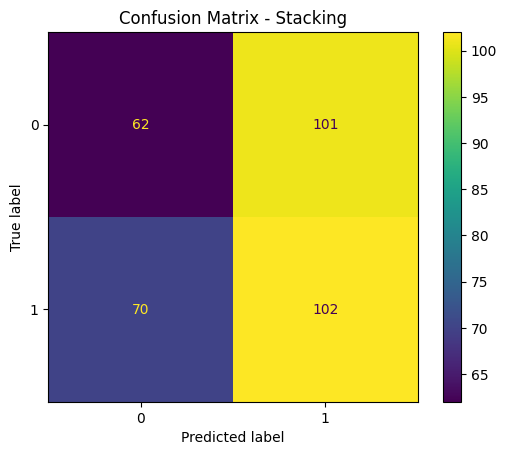

In [17]:
# ---------- Evaluate final stack ----------
if hasattr(stack, "predict_proba"):
    y_valid_proba_stack = stack.predict_proba(X_valid_scaled)[:,1]
else:
    y_valid_proba_stack = stack.predict(X_valid_scaled)

auc_stack = roc_auc_score(y_valid, y_valid_proba_stack)
y_valid_pred = stack.predict(X_valid_scaled)
print(f"\n🏆 Stacking Validation AUC: {auc_stack:.4f}")
print("\nClassification report (stack):\n", classification_report(y_valid, y_valid_pred))
ConfusionMatrixDisplay.from_estimator(stack, X_valid_scaled, y_valid)
plt.title("Confusion Matrix - Stacking")
plt.show()


In [ ]:
# ---------- Save best model (stack) and scaler ----------
with open('best_stock_model.pkl', 'wb') as f:
    pickle.dump(stack, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nSaved: best_stock_model.pkl and scaler.pkl")


Saved: best_stock_model.pkl and scaler.pkl


In [ ]:
# =============================================================
# 🚀 Auto-update: Fetch data & retrain every 5 minutes
# =============================================================

import os
import time
import datetime
import requests
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# =============================================================
# ⚙️ CONFIG
# =============================================================
FINNHUB_API_KEY = "d3coi31r01qmnfgekpl0d3coi31r01qmnfgekplg"
BASE_URL = "https://finnhub.io/api/v1"
DATA_DIR = "data"  # store CSVs here

# ✅ Ensure folder exists
os.makedirs(DATA_DIR, exist_ok=True)

# ✅ Top 10 stocks to auto-update
stock_list = [
    "AAPL", "MSFT", "GOOG", "AMZN", "TSLA",
    "META", "NVDA", "NFLX", "JPM", "BABA"
]


# =============================================================
# 📈 Helper: RSI Calculation
# =============================================================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=period).mean()
    loss = -delta.clip(upper=0).rolling(window=period).mean()
    rs = gain / (loss.replace(0, 1e-8))
    return 100 - (100 / (1 + rs))


# =============================================================
# 🧠 Fetch latest real-time quote
# =============================================================
def fetch_latest_quote(symbol):
    """Fetch real-time stock data from Finnhub"""
    url = f"{BASE_URL}/quote"
    params = {"symbol": symbol, "token": FINNHUB_API_KEY}
    try:
        res = requests.get(url, params=params)
        res.raise_for_status()
        d = res.json()
        return {
            "Date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "Open": d.get("o", 0),
            "High": d.get("h", 0),
            "Low": d.get("l", 0),
            "Close": d.get("c", 0),
            "Volume": d.get("v", 0),
            "Adj_Close": d.get("pc", 0),
        }
    except Exception as e:
        print(f"❌ Error fetching {symbol}: {e}")
        return None


# =============================================================
# 💾 Append fetched data to CSV (for each symbol)
# =============================================================
def update_csv(symbol, new_row):
    filename = os.path.join(DATA_DIR, f"{symbol}.csv")

    df_new = pd.DataFrame([new_row])
    if os.path.exists(filename):
        df_old = pd.read_csv(filename)
        df = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df = df_new

    df.to_csv(filename, index=False)
    print(f"✅ Updated {filename} ({len(df)} records)")


# =============================================================
# 🔁 Retrain model for all stocks combined
# =============================================================
def retrain_all_stocks():
    all_dfs = []

    for symbol in stock_list:
        path = os.path.join(DATA_DIR, f"{symbol}.csv")
        try:
            if not os.path.exists(path):
                print(f"⚠️ {symbol}: CSV not found, skipping.")
                continue
            df = pd.read_csv(path)
            if df.empty:
                print(f"⚠️ {symbol}: Empty CSV, skipping.")
                continue
            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ {symbol}: Error reading CSV → {e}")
            continue

    if not all_dfs:
        print("⚠️ No valid data found — skipping retrain.")
        return

    df_all = pd.concat(all_dfs, ignore_index=True)
    if len(df_all) < 50:
        print(f"⚠️ Insufficient data ({len(df_all)} rows) — skipping retrain.")
        return

    # ---- Feature Engineering ----
    df_all['return_1'] = df_all['Close'].pct_change(1)
    df_all['rsi_14'] = compute_rsi(df_all['Close'])
    df_all['target'] = (df_all['Close'].shift(-1) > df_all['Close']).astype(int)
    df_all = df_all.dropna().reset_index(drop=True)

    X = df_all[['Open','High','Low','Close','Volume','return_1','rsi_14']]
    y = df_all['target']

    if len(X) == 0:
        print("⚠️ No valid samples for training.")
        return

    # ---- Train new model ----
    new_scaler = StandardScaler()
    X_scaled = new_scaler.fit_transform(X)

    new_model = RandomForestClassifier(n_estimators=300, random_state=42)
    new_model.fit(X_scaled, y)

    # ---- Save updated model & scaler ----
    joblib.dump(new_model, "best_stock_model.pkl")
    joblib.dump(new_scaler, "scaler.pkl")

    print(f"✅ Retrained model with {len(X)} samples at {datetime.datetime.now().strftime('%H:%M:%S')}")


# =============================================================
# 🕒 Continuous Loop — fetch + update + retrain every 5 min
# =============================================================
print("🚀 Auto data fetch & retrain started... (Press Stop to exit)")

while True:
    for symbol in stock_list:
        data = fetch_latest_quote(symbol)
        if data:
            update_csv(symbol, data)

    retrain_all_stocks()
    print("⏳ Sleeping for 5 minutes...\n")
    time.sleep(300)  # 5 minutes


🚀 Auto data fetch & retrain started... (Press Stop to exit)
✅ Updated data\AAPL.csv (1 records)
✅ Updated data\MSFT.csv (1 records)
✅ Updated data\GOOG.csv (1 records)
✅ Updated data\AMZN.csv (1 records)
✅ Updated data\TSLA.csv (1 records)
✅ Updated data\META.csv (1 records)
✅ Updated data\NVDA.csv (1 records)
✅ Updated data\NFLX.csv (1 records)
✅ Updated data\JPM.csv (1 records)
✅ Updated data\BABA.csv (1 records)
⚠️ Insufficient data (10 rows) — skipping retrain.
⏳ Sleeping for 5 minutes...

✅ Updated data\AAPL.csv (2 records)
✅ Updated data\MSFT.csv (2 records)
✅ Updated data\GOOG.csv (2 records)
✅ Updated data\AMZN.csv (2 records)
✅ Updated data\TSLA.csv (2 records)
✅ Updated data\META.csv (2 records)
✅ Updated data\NVDA.csv (2 records)
✅ Updated data\NFLX.csv (2 records)
✅ Updated data\JPM.csv (2 records)
✅ Updated data\BABA.csv (2 records)
⚠️ Insufficient data (20 rows) — skipping retrain.
⏳ Sleeping for 5 minutes...

✅ Updated data\AAPL.csv (3 records)
✅ Updated data\MSFT.csv (3